In [83]:
from rdflib import Graph, Namespace
import matplotlib.pyplot as plt
import networkx as nx
import json

In [84]:
# Define namespaces
DS = Namespace("http://darksouls.ontology/")
SCHEMA = Namespace("https://schema.org/")

def load_knowledge_graph(ttl_file):

    g = Graph()
    
    # Bind namespaces for prettier output
    g.bind("ds", DS)
    g.bind("schema", SCHEMA)
    g.bind("owl", OWL)
    
    # Parse the TTL file
    print(f"Loading {ttl_file}...")
    g.parse(ttl_file, format="turtle")
    
    print(f"✓ Successfully loaded {len(g)} triples")
    return g

def query_bosses(g):

    query = """
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    
    SELECT ?boss ?name ?souls ?hp
    WHERE {
        ?boss a ds:Boss .
        ?boss schema:name ?name .
        ?boss ds:souls ?souls .
        ?boss ds:healthPoints ?hp .
    }
    ORDER BY DESC(?souls)
    """
    
    results = g.query(query)
    
    print("\n=== BOSSES BY SOUL REWARD ===")
    print(f"{'Boss Name':<35} {'Souls':<10} {'HP':<10}")
    print("-" * 60)
    
    for row in results:
        print(f"{str(row.name):<35} {int(row.souls):<10} {int(row.hp):<10}")

def query_all_weapons(g):

    query = """
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    
    SELECT ?weapon ?name ?str ?dex ?int ?fth ?physDmg ?magicDmg ?fireDmg ?type
    WHERE {
        ?weapon a ?type .
        ?weapon schema:name ?name .
        FILTER(?type = ds:Melee || ?type = ds:Ranged)
        
        OPTIONAL { ?weapon ds:strengthRequirement ?str . }
        OPTIONAL { ?weapon ds:dexterityRequirement ?dex . }
        OPTIONAL { ?weapon ds:intelligenceRequirement ?int . }
        OPTIONAL { ?weapon ds:faithRequirement ?fth . }
        OPTIONAL { ?weapon ds:physicalDamage ?physDmg . }
        OPTIONAL { ?weapon ds:magicDamage ?magicDmg . }
        OPTIONAL { ?weapon ds:fireDamage ?fireDmg . }
    }
    ORDER BY DESC(?physDmg) DESC(?magicDmg)
    """
    
    results = g.query(query)
    
    print("\n=== ALL WEAPONS ===")
    print(f"{'Weapon':<30} {'Type':<8} {'STR':<4} {'DEX':<4} {'INT':<4} {'FTH':<4} {'Phys':<5} {'Mag':<5} {'Fire':<5}")
    print("-" * 85)
    
    for index, row in enumerate(results):
        weapon_type = "Melee" if "Melee" in str(row.type) else "Ranged"
        
        # Handle optional values - display '-' if not present
        str_val = int(row.str) if row.str else '-'
        dex_val = int(row.dex) if row.dex else '-'
        int_val = int(row['int']) if row['int'] else '-'
        fth_val = int(row.fth) if row.fth else '-'
        phys_val = int(row.physDmg) if row.physDmg else '-'
        mag_val = int(row.magicDmg) if row.magicDmg else '-'
        fire_val = int(row.fireDmg) if row.fireDmg else '-'
        
        print(f"{index + 1}. {str(row.name):<30} {weapon_type:<8} {str(str_val):<4} {str(dex_val):<4} {str(int_val):<4} {str(fth_val):<4} {str(phys_val):<5} {str(mag_val):<5} {str(fire_val):<5}")
def find_items_in_area(g, area_name):

    query = f"""
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    
    SELECT DISTINCT ?item ?name ?type
    WHERE {{
        ?item ds:foundIn ?area .
        ?area schema:name "{area_name}" .
        ?item schema:name ?name .
        ?item a ?type .
        FILTER(?type != <http://www.w3.org/2002/07/owl#NamedIndividual>)
    }}
    ORDER BY ?type ?name
    """
    
    results = g.query(query)
    
    print(f"\n=== ITEMS IN {area_name.upper()} ===")
    for row in results:
        item_type = str(row.type).split('/')[-1]
        print(f"  [{item_type}] {row.name}")

def analyze_boss_weaknesses(g):

    query = """
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    
    SELECT ?boss ?name ?weakness
    WHERE {
        ?boss a ds:Boss .
        ?boss schema:name ?name .
        ?boss ds:weakTo ?weakType .
        ?weakType a ds:DamageType .
        ?weakType rdfs:label ?weakness .
    }
    ORDER BY ?name
    """
    
    results = g.query(query)
    
    print("\n=== BOSS WEAKNESSES ===")
    current_boss = None
    for row in results:
        if current_boss != row.name:
            if current_boss:
                print()
            print(f"{row.name}:")
            current_boss = row.name
        print(f"  • Weak to {row.weakness}")

def save_subset_for_testing(g, output_file="darksouls_subset.ttl"):

    subset = Graph()
    subset.bind("ds", DS)
    subset.bind("schema", SCHEMA)
    
    # Get first 5 bosses
    query = """
    PREFIX ds: <http://darksouls.ontology/>
    SELECT ?boss WHERE {
        ?boss a ds:Boss .
    } LIMIT 5
    """
    
    bosses = [row.boss for row in g.query(query)]
    
    # Add all triples related to these bosses
    for boss in bosses:
        for s, p, o in g.triples((boss, None, None)):
            subset.add((s, p, o))
        for s, p, o in g.triples((None, None, boss)):
            subset.add((s, p, o))
    
    # Also add class definitions
    for s, p, o in g.triples((None, RDF.type, OWL.Class)):
        subset.add((s, p, o))
    
    subset.serialize(destination=output_file, format="turtle")
    print(f"\n✓ Saved subset with {len(subset)} triples to {output_file}")

def export_to_json_ld(g, output_file="darksouls.jsonld"):

    g.serialize(destination=output_file, format="json-ld")
    print(f"✓ Exported to JSON-LD: {output_file}")

In [85]:
g = load_knowledge_graph("ontology_individuals.ttl")

query_bosses(g)
query_all_weapons(g)
find_items_in_area(g, "Undead Burg")
analyze_boss_weaknesses(g)

save_subset_for_testing(g)

Loading ontology_individuals.ttl...
✓ Successfully loaded 1867 triples

=== BOSSES BY SOUL REWARD ===
Boss Name                           Souls      HP        
------------------------------------------------------------
Gwyn, Lord of Cinder                70000      4250      
Seath the Scaleless                 60000      7311      
Gravelord Nito                      60000      6750      
Bed of Chaos                        60000      4444      
Four Kings                          60000      8000      
Black Dragon Kalameet               60000      5665      
Manus, Father of the Abyss          60000      6665      
Ornstein and Smough                 50000      4200      
Knight Artorias                     50000      3750      
Iron Golem                          40000      3100      
Sif, the Great Grey Wolf            40000      3432      
Great Grey Wolf Sif                 40000      3432      
Centipede Demon                     40000      4536      
Dark Sun Gwyndolin       

In [86]:
def visualize_with_networkx(g, max_nodes=50):
    
    nx_graph = nx.DiGraph()
    
    # Query to get boss relationships
    query = """
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    
    SELECT ?boss ?name ?area ?areaName ?soul
    WHERE {
        ?boss a ds:Boss .
        ?boss schema:name ?name .
        ?boss ds:locatedIn ?area .
        ?area schema:name ?areaName .
        ?boss ds:drops ?soul .
    }
    LIMIT 15
    """
    
    results = g.query(query)
    
    # Add nodes and edges
    for row in results:
        boss_name = str(row.name)
        area_name = str(row.areaName)
        
        nx_graph.add_node(boss_name, node_type='boss')
        nx_graph.add_node(area_name, node_type='area')
        nx_graph.add_edge(area_name, boss_name, label='contains')
    
    # Use hierarchical layout for clearer structure
    pos = nx.spring_layout(nx_graph, k=3, iterations=100, seed=42)
    
    # Draw with white background
    fig, ax = plt.subplots(figsize=(20, 14), facecolor='white')
    ax.set_facecolor('white')
    
    # Separate nodes by type
    boss_nodes = [n for n, d in nx_graph.nodes(data=True) if d.get('node_type') == 'boss']
    area_nodes = [n for n, d in nx_graph.nodes(data=True) if d.get('node_type') == 'area']
    
    # Draw nodes with better visibility
    nx.draw_networkx_nodes(nx_graph, pos, nodelist=boss_nodes, 
                          node_color='#DC143C', node_size=3000, alpha=0.95, 
                          label='Bosses', edgecolors='black', linewidths=2)
    nx.draw_networkx_nodes(nx_graph, pos, nodelist=area_nodes, 
                          node_color='#87CEEB', node_size=2500, alpha=0.95, 
                          label='Areas', edgecolors='black', linewidths=2)
    
    # Draw edges with better visibility
    nx.draw_networkx_edges(nx_graph, pos, edge_color='#404040', 
                          arrows=True, arrowsize=25, alpha=0.6, 
                          width=2, arrowstyle='->', connectionstyle='arc3,rad=0.1')
    
    # Draw labels with white background boxes for readability
    nx.draw_networkx_labels(nx_graph, pos, font_size=11, font_weight='bold',
                           font_family='sans-serif',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                                    edgecolor='black', alpha=0.8))
    
    plt.title("Dark Souls Knowledge Graph: Bosses and Areas", 
             fontsize=20, fontweight='bold', pad=20)
    plt.legend(loc='upper left', fontsize=14, frameon=True, shadow=True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('darksouls_graph_networkx.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    print("✓ Saved: darksouls_graph_networkx.png")
    plt.show()

def visualize_weapon_damage_types(g):
    """Visualize weapons by damage type"""
    
    query = """
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    
    SELECT ?weapon ?name ?physDmg ?magicDmg ?fireDmg ?lightDmg
    WHERE {
        ?weapon a ds:Melee .
        ?weapon schema:name ?name .
        OPTIONAL { ?weapon ds:physicalDamage ?physDmg . }
        OPTIONAL { ?weapon ds:magicDamage ?magicDmg . }
        OPTIONAL { ?weapon ds:fireDamage ?fireDmg . }
        OPTIONAL { ?weapon ds:lightningDamage ?lightDmg . }
    }
    LIMIT 20
    """
    
    results = list(g.query(query))
    
    # Prepare data
    weapons = []
    phys_dmg = []
    magic_dmg = []
    fire_dmg = []
    light_dmg = []
    
    for row in results:
        weapons.append(str(row.name)[:20])  # Truncate long names
        phys_dmg.append(int(row.physDmg) if row.physDmg else 0)
        magic_dmg.append(int(row.magicDmg) if row.magicDmg else 0)
        fire_dmg.append(int(row.fireDmg) if row.fireDmg else 0)
        light_dmg.append(int(row.lightDmg) if row.lightDmg else 0)
    
    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(16, 10), facecolor='white')
    
    x = range(len(weapons))
    width = 0.8
    
    p1 = ax.bar(x, phys_dmg, width, label='Physical', color='#8B4513', edgecolor='black')
    p2 = ax.bar(x, magic_dmg, width, bottom=phys_dmg, label='Magic', color='#4169E1', edgecolor='black')
    
    bottom2 = [p + m for p, m in zip(phys_dmg, magic_dmg)]
    p3 = ax.bar(x, fire_dmg, width, bottom=bottom2, label='Fire', color='#FF4500', edgecolor='black')
    
    bottom3 = [b + f for b, f in zip(bottom2, fire_dmg)]
    p4 = ax.bar(x, light_dmg, width, bottom=bottom3, label='Lightning', color='#FFD700', edgecolor='black')
    
    ax.set_xlabel('Weapons', fontsize=14, fontweight='bold')
    ax.set_ylabel('Damage', fontsize=14, fontweight='bold')
    ax.set_title('Dark Souls Weapon Damage Breakdown', fontsize=18, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(weapons, rotation=45, ha='right', fontsize=10)
    ax.legend(loc='upper right', fontsize=12, frameon=True, shadow=True)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.savefig('darksouls_weapon_damage.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("✓ Saved: darksouls_weapon_damage.png")
    plt.show()


def visualize_boss_stats_comparison(g):
    """Compare boss health and soul rewards"""
    
    query = """
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    
    SELECT ?boss ?name ?hp ?souls
    WHERE {
        ?boss a ds:Boss .
        ?boss schema:name ?name .
        ?boss ds:healthPoints ?hp .
        ?boss ds:souls ?souls .
    }
    ORDER BY DESC(?souls)
    LIMIT 15
    """
    
    results = list(g.query(query))
    
    # Prepare data
    boss_names = [str(row.name) for row in results]
    hp_values = [int(row.hp) for row in results]
    soul_values = [int(row.souls) for row in results]
    
    # Create dual-axis plot
    fig, ax1 = plt.subplots(figsize=(18, 10), facecolor='white')
    
    x = range(len(boss_names))
    
    # HP bars
    color1 = '#DC143C'
    ax1.set_xlabel('Boss', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Health Points', fontsize=14, fontweight='bold', color=color1)
    bars1 = ax1.bar([i - 0.2 for i in x], hp_values, 0.4, label='HP', 
                    color=color1, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Soul rewards on second axis
    ax2 = ax1.twinx()
    color2 = '#FFD700'
    ax2.set_ylabel('Soul Reward', fontsize=14, fontweight='bold', color=color2)
    bars2 = ax2.bar([i + 0.2 for i in x], soul_values, 0.4, label='Souls', 
                    color=color2, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Labels and formatting
    ax1.set_xticks(x)
    ax1.set_xticklabels(boss_names, rotation=45, ha='right', fontsize=10, fontweight='bold')
    ax1.set_title('Dark Souls Boss Stats: Health vs Soul Rewards', 
                 fontsize=18, fontweight='bold', pad=20)
    
    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', 
              fontsize=12, frameon=True, shadow=True)
    
    plt.tight_layout()
    plt.savefig('darksouls_boss_stats.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("✓ Saved: darksouls_boss_stats.png")
    plt.show()


def visualize_area_connectivity(g):
    """Show how areas connect to each other"""
    
    query = """
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    
    SELECT ?area1 ?name1 ?area2 ?name2
    WHERE {
        ?area1 ds:connectsTo ?area2 .
        ?area1 schema:name ?name1 .
        ?area2 schema:name ?name2 .
    }
    """
    
    results = g.query(query)
    
    nx_graph = nx.Graph()  # Undirected for area connections
    
    for row in results:
        area1 = str(row.name1)
        area2 = str(row.name2)
        nx_graph.add_edge(area1, area2)
    
    # Use circular layout for area map
    pos = nx.kamada_kawai_layout(nx_graph)
    
    fig, ax = plt.subplots(figsize=(20, 20), facecolor='white')
    ax.set_facecolor('white')
    
    # Draw nodes
    nx.draw_networkx_nodes(nx_graph, pos, 
                          node_color='#2E8B57', node_size=4000, alpha=0.9,
                          edgecolors='black', linewidths=3)
    
    # Draw edges
    nx.draw_networkx_edges(nx_graph, pos, 
                          edge_color='#696969', width=3, alpha=0.6)
    
    # Draw labels
    nx.draw_networkx_labels(nx_graph, pos, font_size=12, font_weight='bold',
                           font_family='sans-serif',
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                                    edgecolor='black', alpha=0.9, linewidth=2))
    
    plt.title("Dark Souls World Map: Area Connectivity", 
             fontsize=22, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('darksouls_area_map.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("✓ Saved: darksouls_area_map.png")
    plt.show()


def visualize_boss_weaknesses_network(g):
    """Network showing bosses and their weaknesses"""
    
    query = """
    PREFIX ds: <http://darksouls.ontology/>
    PREFIX schema: <https://schema.org/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    
    SELECT ?boss ?bossName ?damageType ?typeName
    WHERE {
        ?boss a ds:Boss .
        ?boss schema:name ?bossName .
        ?boss ds:weakTo ?damageType .
        ?damageType rdfs:label ?typeName .
    }
    LIMIT 30
    """
    
    results = g.query(query)
    
    nx_graph = nx.DiGraph()
    
    for row in results:
        boss = str(row.bossName)
        weakness = str(row.typeName)
        
        nx_graph.add_node(boss, node_type='boss')
        nx_graph.add_node(weakness, node_type='damage')
        nx_graph.add_edge(boss, weakness, label='weak to')
    
    # Use bipartite layout
    boss_nodes = [n for n, d in nx_graph.nodes(data=True) if d.get('node_type') == 'boss']
    damage_nodes = [n for n, d in nx_graph.nodes(data=True) if d.get('node_type') == 'damage']
    
    pos = {}
    for i, node in enumerate(boss_nodes):
        pos[node] = (0, i * 2)
    for i, node in enumerate(damage_nodes):
        pos[node] = (3, i * 3)
    
    fig, ax = plt.subplots(figsize=(18, 14), facecolor='white')
    ax.set_facecolor('white')
    
    # Draw nodes
    nx.draw_networkx_nodes(nx_graph, pos, nodelist=boss_nodes,
                          node_color='#B22222', node_size=2500, alpha=0.9,
                          label='Bosses', edgecolors='black', linewidths=2)
    nx.draw_networkx_nodes(nx_graph, pos, nodelist=damage_nodes,
                          node_color='#FF8C00', node_size=2000, alpha=0.9,
                          label='Damage Types', edgecolors='black', linewidths=2)
    
    # Draw edges
    nx.draw_networkx_edges(nx_graph, pos, edge_color='#404040',
                          arrows=True, arrowsize=20, alpha=0.5, width=2,
                          connectionstyle='arc3,rad=0.2')
    
    # Draw labels
    nx.draw_networkx_labels(nx_graph, pos, font_size=10, font_weight='bold',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                                    edgecolor='black', alpha=0.85))
    
    plt.title("Dark Souls Boss Weaknesses Network", fontsize=20, fontweight='bold', pad=20)
    plt.legend(loc='upper right', fontsize=14, frameon=True, shadow=True)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('darksouls_boss_weaknesses.png', dpi=300, bbox_inches='tight', facecolor='white')
    print("✓ Saved: darksouls_boss_weaknesses.png")
    plt.show()

✓ Saved: darksouls_graph_networkx.png


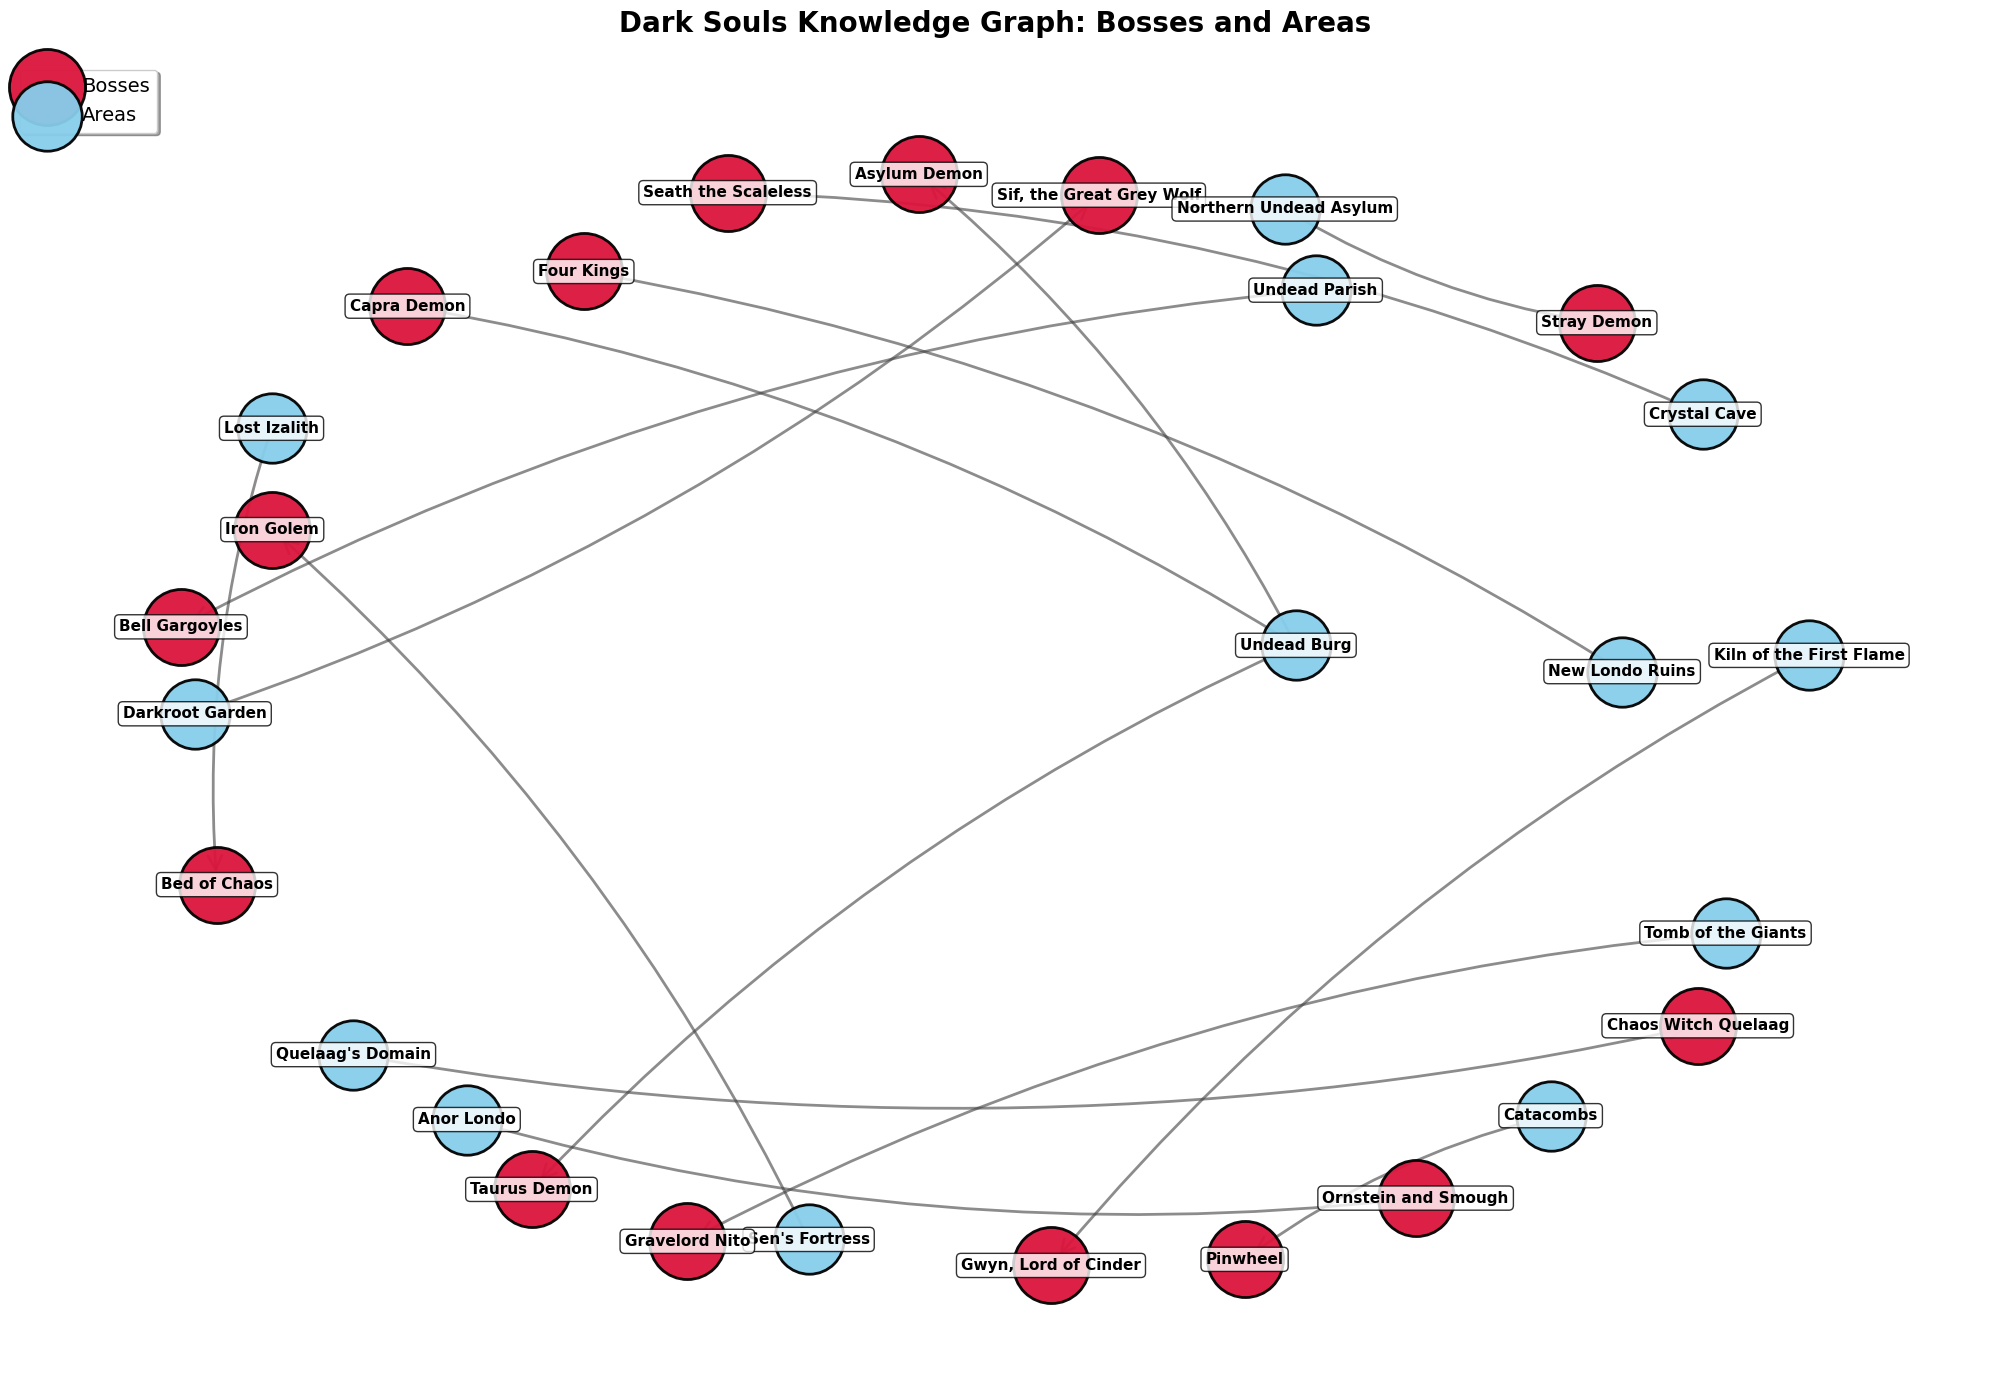

In [87]:
g = Graph()
g.parse("ontology_individuals.ttl", format="turtle")
visualize_with_networkx(g)

In [ ]:
# Load graph once
g = Graph()
g.parse("ontology_individuals.ttl", format="turtle")

# Run all visualizations
print("\n=== CREATING ENHANCED VISUALIZATIONS ===\n")
visualize_with_networkx(g)
visualize_weapon_damage_types(g)
visualize_boss_stats_comparison(g)
visualize_area_connectivity(g)
visualize_boss_weaknesses_network(g)

print("\n✓ All visualizations complete!")